In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from redist import modifier
from redist import plot
from ksnunu_utils import * 

from copy import deepcopy

/tmp/user/20892/ipykernel_1775015/32741661.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Binning for $B \to K^* \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [3]:
binning = np.linspace(0.0, 19.25, 10+1) 
bin_cents = (binning[:-1] + binning[1:])/2

## Define the NP model in WC space

In [4]:
cvl = 10.0
cvr = 4.0
csl = 3.0
csr = 1.0
ctl = 1.0

## Compute number of samples to produce

In [5]:
# current lumi
lc = 362

# total lumi
lf = 50000

# current BB evts
ec = 387e6

# total BB evts
et = ec * lf / lc

## Generate some SM samples

In [6]:
p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=19.25)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^*-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->K^*nunu::BR', p, k, o)
SMBR = obs.evaluate()

# SMsamples = int(ec*SMBR)
SMsamples = int(et*SMBR)

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1230))

/filer/z-sv-pool12c/l/Lorenz.Gaertner/micromamba/envs/redist/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Apply efficiency


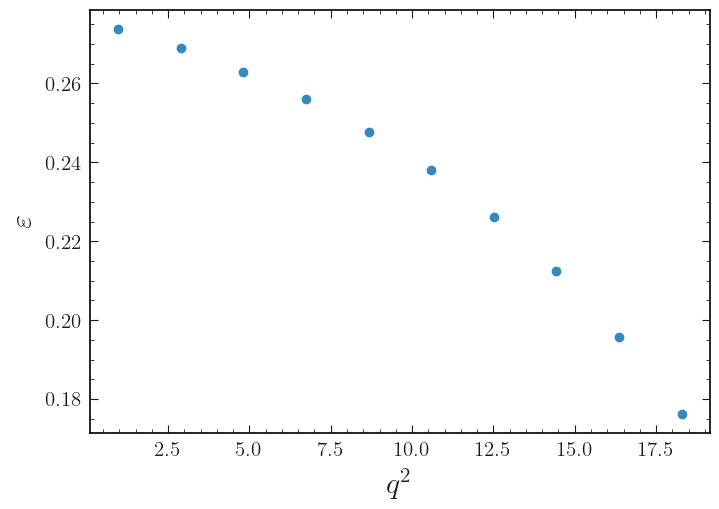

In [7]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

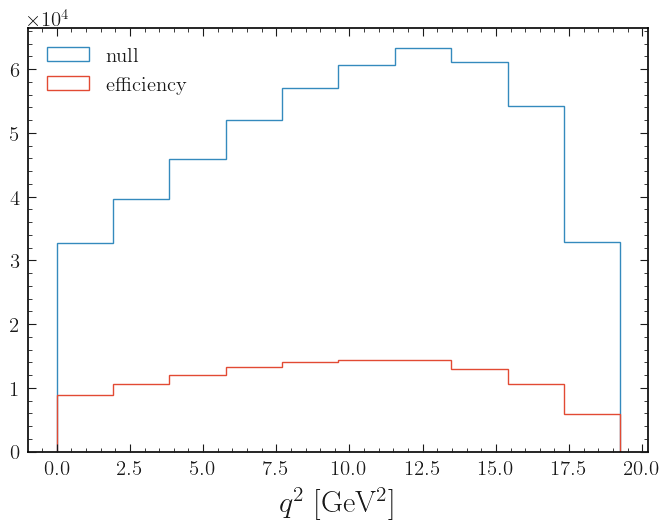

In [8]:
plt.hist(null_samples, binning, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples, binning, weights = efficiency(null_samples), histtype='step', label='efficiency')

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [9]:
p['sbnunu::Re{cVL}'].set(cvl)
p['sbnunu::Re{cVR}'].set(cvr)
p['sbnunu::Re{cSL}'].set(csl)
p['sbnunu::Re{cSR}'].set(csr)
p['sbnunu::Re{cTL}'].set(ctl)


BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=9999))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

### Apply efficiency


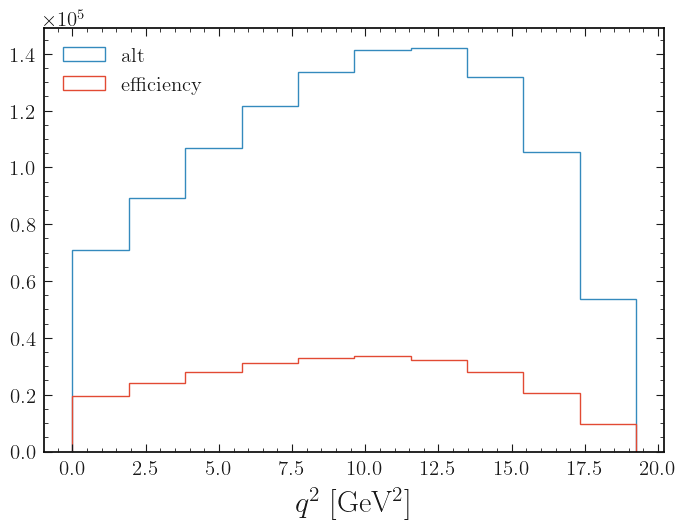

In [10]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
alt_yields, _, _ = plt.hist(alt_samples, binning, weights = efficiency(alt_samples), histtype='step', label='efficiency')

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Setup

In [11]:
null = null_pred()
alt = alt_pred()

In [12]:
ana  = analysis()

v0   = ana.parameters['B->K^*::alpha^V_0@BSZ2015'  ].evaluate()
v1   = ana.parameters['B->K^*::alpha^V_1@BSZ2015'  ].evaluate()
v2   = ana.parameters['B->K^*::alpha^V_2@BSZ2015'  ].evaluate()
a00  = ana.parameters['B->K^*::alpha^A0_0@BSZ2015' ].evaluate() 
a01  = ana.parameters['B->K^*::alpha^A0_1@BSZ2015' ].evaluate() 
a02  = ana.parameters['B->K^*::alpha^A0_2@BSZ2015' ].evaluate()
a10  = ana.parameters['B->K^*::alpha^A1_0@BSZ2015' ].evaluate()
a11  = ana.parameters['B->K^*::alpha^A1_1@BSZ2015' ].evaluate()
a12  = ana.parameters['B->K^*::alpha^A1_2@BSZ2015' ].evaluate()
a121 = ana.parameters['B->K^*::alpha^A12_1@BSZ2015'].evaluate()
a122 = ana.parameters['B->K^*::alpha^A12_2@BSZ2015'].evaluate()
t10  = ana.parameters['B->K^*::alpha^T1_0@BSZ2015' ].evaluate()
t11  = ana.parameters['B->K^*::alpha^T1_1@BSZ2015' ].evaluate()
t12  = ana.parameters['B->K^*::alpha^T1_2@BSZ2015' ].evaluate()
t21  = ana.parameters['B->K^*::alpha^T2_1@BSZ2015' ].evaluate()
t22  = ana.parameters['B->K^*::alpha^T2_2@BSZ2015' ].evaluate()
t230 = ana.parameters['B->K^*::alpha^T23_0@BSZ2015'].evaluate()
t231 = ana.parameters['B->K^*::alpha^T23_1@BSZ2015'].evaluate()
t232 = ana.parameters['B->K^*::alpha^T23_2@BSZ2015'].evaluate()

In [13]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana, chains = 5, samples = 10000)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:  20%|██        | 1/5 [00:00<00:00,  5.56it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]            Markov chain self adaptation failed; trying diagonalization
Diagonalization succeeded
Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]            Markov chain self adaptation failed; trying diagonalization
Diagonalization succeeded


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.001429,-0.000783,-0.063255,0.000804,0.003936,-0.000127,0.013502,0.050576,0.001198,-0.003037,-0.063048,0.000579,0.001062,0.012997,0.003999,0.013892,0.001080,0.001477,-0.019931
1,-0.000783,0.066039,0.376485,-0.001003,-0.001022,-0.019515,0.021904,0.149820,-0.003431,0.014736,0.187574,-0.000915,-0.003302,-0.073291,-0.008298,-0.054909,-0.002483,-0.003942,0.050023
2,-0.063255,0.376485,7.817416,-0.024235,-0.168423,-0.088139,-0.580625,-1.597669,-0.050883,0.092806,4.035921,-0.008688,-0.105557,-1.991418,-0.192241,-1.528172,-0.042420,0.023533,1.301351
3,0.000804,-0.001003,-0.024235,0.000880,0.003617,-0.003752,0.006871,0.027338,0.001350,-0.003249,-0.063462,0.000831,0.000335,-0.005884,0.004216,0.004411,0.001141,0.003286,-0.010230
4,0.003936,-0.001022,-0.168423,0.003617,0.028578,0.049568,0.057137,0.276662,0.006094,-0.011900,-0.335306,0.003475,0.003863,0.010220,0.019150,0.034429,0.005169,0.013039,-0.052845
5,-0.000127,-0.019515,-0.088139,-0.003752,0.049568,0.546352,0.078496,0.579064,-0.001101,-0.009386,0.020145,-0.002393,0.008470,0.179110,-0.011384,0.026917,-0.001420,-0.010562,-0.001050
6,0.013502,0.021904,-0.580625,0.006871,0.057137,0.078496,0.243404,1.237767,0.009733,-0.015594,-0.604531,0.004246,0.016193,0.225147,0.038735,0.179226,0.009345,0.001337,-0.228884
7,0.050576,0.149820,-1.597669,0.027338,0.276662,0.579064,1.237767,7.096278,0.037091,-0.053165,-2.230731,0.016978,0.073204,0.981699,0.158164,0.722044,0.037040,-0.009231,-0.950141
8,0.001198,-0.003431,-0.050883,0.001350,0.006094,-0.001101,0.009733,0.037091,0.002539,-0.006929,-0.135258,0.001352,0.000671,-0.006462,0.007119,0.009803,0.001911,0.005508,-0.018278
9,-0.003037,0.014736,0.092806,-0.003249,-0.011900,-0.009386,-0.015594,-0.053165,-0.006929,0.046410,0.409080,-0.003307,-0.000765,0.028532,-0.016105,-0.012694,-0.004814,-0.014018,0.057059


In [14]:
cvlSM = eos.Parameters()['sbnunu::Re{cVL}'].evaluate()

new_params = {
                'cvl'   :{'inits': (cvlSM,), 'bounds':  ((3., 14.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'FFKs'    :{'inits': (v0, v1, v2, a00, a01, a02, a10, a11, a12, a121, a122, t10, t11, t12, t21, t22, t230, t231, t232), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

In [15]:
spec = {
  "channels": [
    {
      "name": "B->Ksnunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
basemodel = pyhf.Model(spec)

custom_mod = {
                "name": "ksnunu_theory",
                "type": "ksnunu",
                "data":{"expr": "ksnunu_weight_fn"}
              }

## Check convergence for different binnings

In [16]:
max_bins = 0

#loop random  models
for m in range(100):
    np.random.seed(123+m)
    cvl, cvr, csl, csr, ctl = np.random.normal(0.0, 10.0, 5)
    cvl += cvlSM
    
    old = None
    #loop over number of bins
    for n in range(1, 100):
        q2binning = np.linspace(0.0, 19.25, n+1)

        mapping_dist = modifier.map(null_samples.flatten(), [null_samples.flatten()], binning, [q2binning])
        mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

        cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='ksnunu')

        model = modifier.add_to_model(deepcopy(basemodel), ['B->Ksnunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
        
        init = model.config.suggested_init()
        init[model.config.par_map['cvl']['slice']] = [cvl]
        init[model.config.par_map['cvr']['slice']] = [cvr]
        init[model.config.par_map['csl']['slice']] = [csl]
        init[model.config.par_map['csr']['slice']] = [csr]
        init[model.config.par_map['ctl']['slice']] = [ctl]
        
        try:
            new = model.expected_actualdata(init)
            diff = abs(new-old)/old
            # check if the difference is larger than 1%
            if not any(diff > 1e-2):
                max_bins = max(max_bins, n)
                break
        except:
            pass
        
        old = model.expected_actualdata(init)
        
print('max bins', max_bins)

max bins 22


## Compare to data

In [17]:
cvl = 10.0
cvr = 4.0
csl = 3.0
csr = 1.0
ctl = 1.0

new = []

#loop over number of bins
maxbins = 30
for n in range(1, maxbins):
    q2binning = np.linspace(0.0, 22.9, n+1)

    mapping_dist = modifier.map(null_samples.flatten(), [null_samples.flatten()], binning, [q2binning])
    mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

    cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='ksnunu')

    model = modifier.add_to_model(deepcopy(basemodel), ['B->Ksnunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
    
    init = model.config.suggested_init()
    init[model.config.par_map['cvl']['slice']] = [cvl]
    init[model.config.par_map['cvr']['slice']] = [cvr]
    init[model.config.par_map['csl']['slice']] = [csl]
    init[model.config.par_map['csr']['slice']] = [csr]
    init[model.config.par_map['ctl']['slice']] = [ctl]
    
    new.append(model.expected_actualdata(init))


/filer/z-sv-pool12c/l/Lorenz.Gaertner/micromamba/envs/redist/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


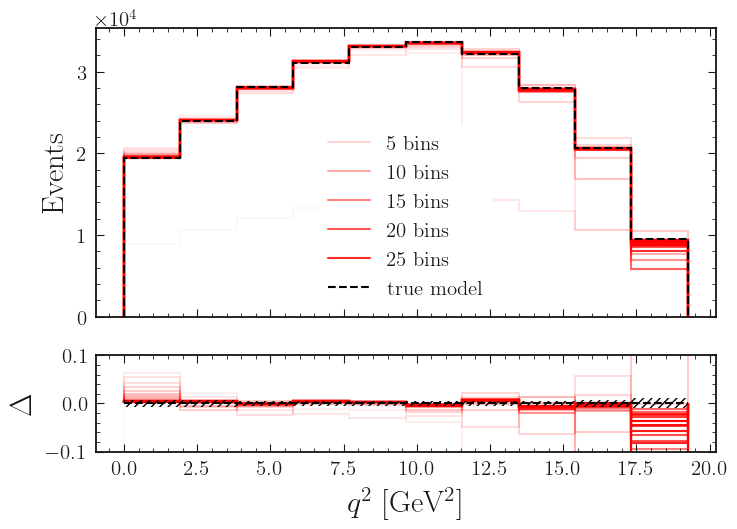

In [18]:
fig, ax = plt.subplots(2,1,sharex=True, height_ratios=[3, 1])

for i, n in enumerate(new, start = 1):
    if i%5 == 0:
        ax[0].stairs(n, binning, color='r', alpha=i/maxbins, linewidth=1.5, label=f'{i} bins')
    else:
        ax[0].stairs(n, binning, color='r', alpha=i/maxbins, linewidth=1.5)
ax[0].stairs(alt_yields, binning, color='k', linestyle='dashed', linewidth=1.5, label='true model')

ax[0].set_ylabel(r'Events')
ax[0].legend()

for i, n in enumerate(new, start = 1):
    ax[1].stairs((n-alt_yields)/alt_yields, binning, color='r', alpha=i/maxbins, linewidth=1.5)
ax[1].stairs( np.sqrt(1/alt_yields), binning, color='k', linewidth=0., hatch='////')
ax[1].stairs(-np.sqrt(1/alt_yields), binning, color='k', linewidth=0., hatch='////')
ax[1].hlines(y=0, xmin=binning[0], xmax=binning[-1], color='k', linestyle='dashed', linewidth=1.5)

ax[1].set_ylim(-0.1, 0.1)

ax[1].set_xlabel(r'$q^2$ [GeV$^2$]')
ax[1].set_ylabel(r'$\Delta$')

# file = '../results/knunu_binning.pdf'
# plt.savefig(file)

plt.show()

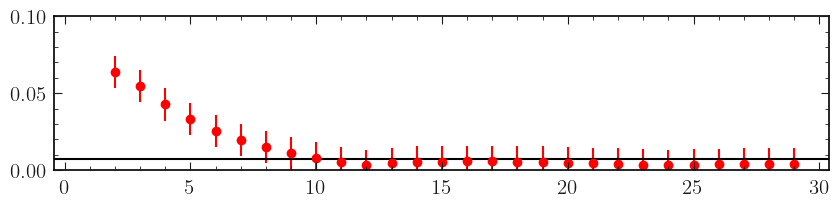

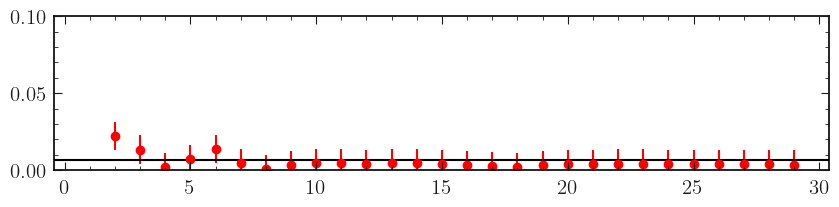

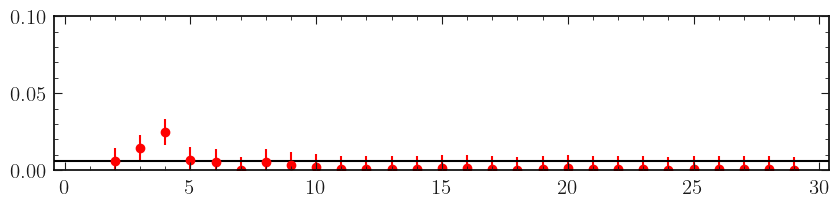

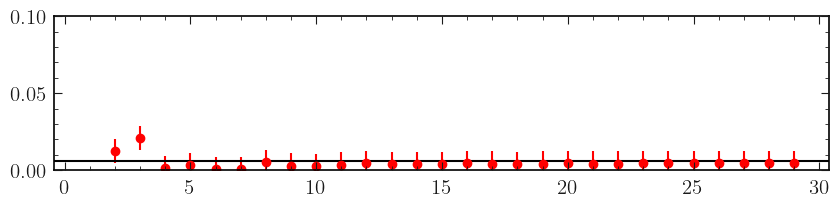

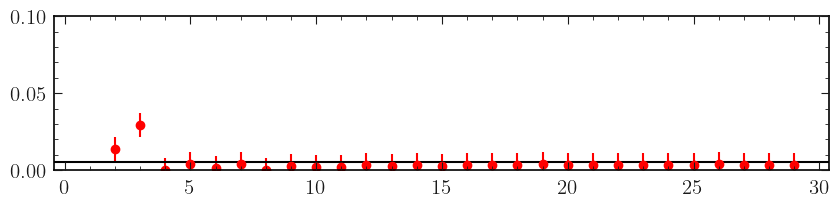

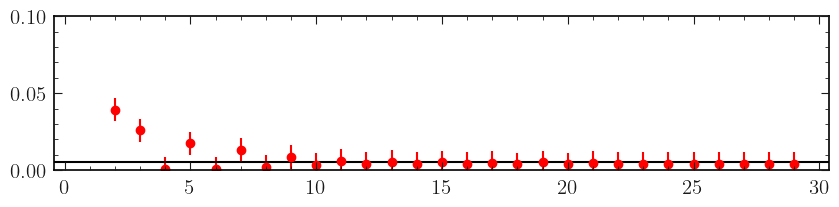

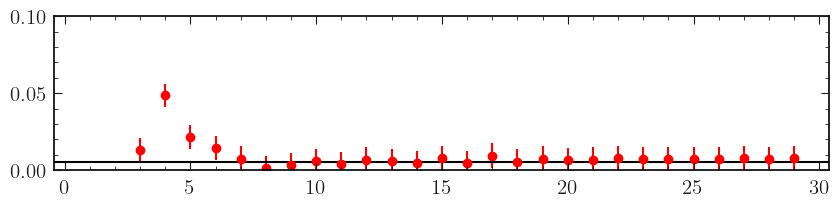

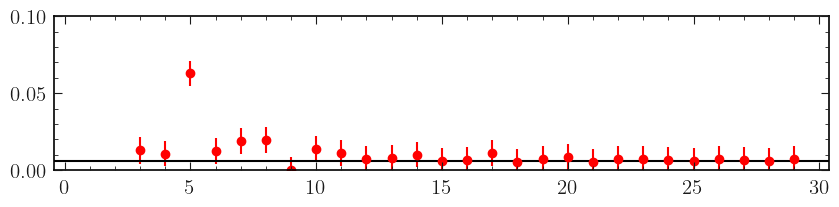

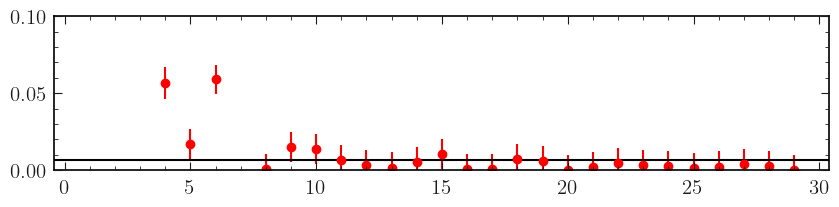

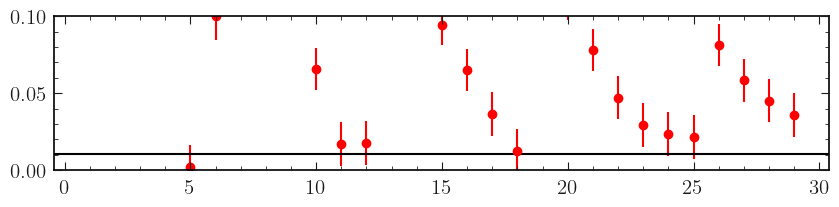

In [19]:
new = np.array(new)
diffs = abs(new-alt_yields)/alt_yields
errors = new/alt_yields * (1/new + 1/alt_yields)**0.5
for d, e, s in zip(diffs.T, errors.T,  np.sqrt(1/alt_yields)):
    plt.figure(figsize=(10,2))
    plt.errorbar(np.arange(1, len(diffs)+1), d, yerr=e, fmt='o', color='r', linewidth=1.5)
    plt.axhline(s, color='k')
    plt.ylim(0, 0.1)
    plt.show()